In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [3]:
### RECEIVE 20,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)

In [4]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

    return model

In [5]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('mean_squared_error', 'min'),
                     max_epochs=25,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5)

In [6]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.15, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.1647 - mean_squared_error: 0.1647 - val_loss: 0.1296 - val_mean_squared_error: 0.1296
Epoch 2/3
17000/17000 - 1s - loss: 0.1022 - mean_squared_error: 0.1022 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 3/3
17000/17000 - 1s - loss: 0.0591 - mean_squared_error: 0.0591 - val_loss: 0.0438 - val_mean_squared_error: 0.0438


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.1751 - mean_squared_error: 0.1751 - val_loss: 0.1481 - val_mean_squared_error: 0.1481
Epoch 2/3
17000/17000 - 1s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1136 - val_mean_squared_error: 0.1136
Epoch 3/3
17000/17000 - 1s - loss: 0.1104 - mean_squared_error: 0.1104 - val_loss: 0.1047 - val_mean_squared_error: 0.1047


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/3
17000/17000 - 2s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.1026 - val_mean_squared_error: 0.1026
Epoch 3/3
17000/17000 - 2s - loss: 0.0830 - mean_squared_error: 0.0830 - val_loss: 0.0378 - val_mean_squared_error: 0.0378


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.1523 - mean_squared_error: 0.1523 - val_loss: 0.1088 - val_mean_squared_error: 0.1088
Epoch 2/3
17000/17000 - 1s - loss: 0.0775 - mean_squared_error: 0.0775 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 3/3
17000/17000 - 2s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0244 - val_mean_squared_error: 0.0244


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 2/3
17000/17000 - 1s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 8.7103e-04 - val_mean_squared_error: 8.7103e-04
Epoch 3/3
17000/17000 - 1s - loss: 6.6124e-04 - mean_squared_error: 6.6124e-04 - val_loss: 5.2054e-04 - val_mean_squared_error: 5.2054e-04


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2/3
17000/17000 - 2s - loss: 0.3671 - mean_squared_error: 0.3671 - val_loss: 0.4078 - val_mean_squared_error: 0.4078
Epoch 3/3
17000/17000 - 2s - loss: 0.4066 - mean_squared_error: 0.4066 - val_loss: 0.4098 - val_mean_squared_error: 0.4098


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.1512 - mean_squared_error: 0.1512 - val_loss: 0.1050 - val_mean_squared_error: 0.1050
Epoch 2/3
17000/17000 - 2s - loss: 0.0842 - mean_squared_error: 0.0842 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 3/3
17000/17000 - 2s - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0470 - val_mean_squared_error: 0.0470


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/3
17000/17000 - 2s - loss: 0.1135 - mean_squared_error: 0.1135 - val_loss: 0.2070 - val_mean_squared_error: 0.2070
Epoch 3/3
17000/17000 - 2s - loss: 0.2304 - mean_squared_error: 0.2304 - val_loss: 0.2118 - val_mean_squared_error: 0.2118


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 3s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/3
17000/17000 - 2s - loss: 4.5245e-04 - mean_squared_error: 4.5245e-04 - val_loss: 3.7546e-04 - val_mean_squared_error: 3.7546e-04
Epoch 3/3
17000/17000 - 3s - loss: 4.4250e-04 - mean_squared_error: 4.4250e-04 - val_loss: 5.1216e-04 - val_mean_squared_error: 5.1216e-04


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.1701 - mean_squared_error: 0.1701 - val_loss: 0.1409 - val_mean_squared_error: 0.1409
Epoch 2/3
17000/17000 - 2s - loss: 0.1166 - mean_squared_error: 0.1166 - val_loss: 0.0913 - val_mean_squared_error: 0.0913
Epoch 3/3
17000/17000 - 2s - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0573 - val_mean_squared_error: 0.0573


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 2/3
17000/17000 - 1s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 9.0425e-04 - val_mean_squared_error: 9.0425e-04
Epoch 3/3
17000/17000 - 2s - loss: 6.7751e-04 - mean_squared_error: 6.7751e-04 - val_loss: 4.9704e-04 - val_mean_squared_error: 4.9704e-04


Train on 17000 samples, validate on 3000 samples
Epoch 1/3
17000/17000 - 2s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 2/3
17000/17000 - 2s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.9082e-04 - val_mean_squared_error: 6.9082e-04
Epoch 3/3
17000/17000 - 2s - loss: 5.5679e-04 - mean_squared_error: 5.5679e-04 - val_loss: 4.4842e-04 - val_mean_squared_error: 4.4842e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 3s - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 4.7965e-04 - val_mean_squared_error: 4.7965e-04
Epoch 5/9
17000/17000 - 2s - loss: 4.4272e-04 - mean_squared_error: 4.4272e-04 - val_loss: 4.1671e-04 - val_mean_squared_error: 4.1671e-04
Epoch 6/9
17000/17000 - 2s - loss: 4.5919e-04 - mean_squared_error: 4.5919e-04 - val_loss: 5.1591e-04 - val_mean_squared_error: 5.1591e-04
Epoch 7/9
17000/17000 - 2s - loss: 4.3435e-04 - mean_squared_error: 4.3435e-04 - val_loss: 5.7262e-04 - val_mean_squared_error: 5.7262e-04
Epoch 8/9
17000/17000 - 2s - loss: 4.8616e-04 - mean_squared_error: 4.8616e-04 - val_loss: 4.4584e-04 - val_mean_squared_error: 4.4584e-04
Epoch 9/9
17000/17000 - 2s - loss: 4.2340e-04 - mean_squared_error: 4.2340e-04 - val_loss: 4.6475e-04 - val_mean_squared_error: 4.6475e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 2s - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 5/9
17000/17000 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.1028e-04 - val_mean_squared_error: 7.1028e-04
Epoch 6/9
17000/17000 - 2s - loss: 5.6703e-04 - mean_squared_error: 5.6703e-04 - val_loss: 4.4232e-04 - val_mean_squared_error: 4.4232e-04
Epoch 7/9
17000/17000 - 2s - loss: 4.1993e-04 - mean_squared_error: 4.1993e-04 - val_loss: 3.6887e-04 - val_mean_squared_error: 3.6887e-04
Epoch 8/9
17000/17000 - 2s - loss: 3.7039e-04 - mean_squared_error: 3.7039e-04 - val_loss: 3.6914e-04 - val_mean_squared_error: 3.6914e-04
Epoch 9/9
17000/17000 - 1s - loss: 3.5360e-04 - mean_squared_error: 3.5360e-04 - val_loss: 3.6149e-04 - val_mean_squared_error: 3.6149e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 2s - loss: 0.0539 - mean_squared_error: 0.0539 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 5/9
17000/17000 - 2s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 9.4181e-04 - val_mean_squared_error: 9.4181e-04
Epoch 6/9
17000/17000 - 2s - loss: 6.7495e-04 - mean_squared_error: 6.7495e-04 - val_loss: 4.9671e-04 - val_mean_squared_error: 4.9671e-04
Epoch 7/9
17000/17000 - 2s - loss: 4.5453e-04 - mean_squared_error: 4.5453e-04 - val_loss: 3.8772e-04 - val_mean_squared_error: 3.8772e-04
Epoch 8/9
17000/17000 - 2s - loss: 3.8298e-04 - mean_squared_error: 3.8298e-04 - val_loss: 3.5771e-04 - val_mean_squared_error: 3.5771e-04
Epoch 9/9
17000/17000 - 1s - loss: 3.6125e-04 - mean_squared_error: 3.6125e-04 - val_loss: 3.1951e-04 - val_mean_squared_error: 3.1951e-04


Train on 17000 samples, validate on 3000 samples
Epoch 4/9
17000/17000 - 2s - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 5/9
17000/17000 - 1s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 9.1932e-04 - val_mean_squared_error: 9.1932e-04
Epoch 6/9
17000/17000 - 1s - loss: 6.8565e-04 - mean_squared_error: 6.8565e-04 - val_loss: 5.0315e-04 - val_mean_squared_error: 5.0315e-04
Epoch 7/9
17000/17000 - 1s - loss: 4.5955e-04 - mean_squared_error: 4.5955e-04 - val_loss: 3.9946e-04 - val_mean_squared_error: 3.9946e-04
Epoch 8/9
17000/17000 - 1s - loss: 3.8872e-04 - mean_squared_error: 3.8872e-04 - val_loss: 3.4300e-04 - val_mean_squared_error: 3.4300e-04
Epoch 9/9
17000/17000 - 1s - loss: 3.5635e-04 - mean_squared_error: 3.5635e-04 - val_loss: 3.1897e-04 - val_mean_squared_error: 3.1897e-04


Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 2s - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 11/25
17000/17000 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 7.0489e-04 - val_mean_squared_error: 7.0489e-04
Epoch 12/25
17000/17000 - 2s - loss: 5.6831e-04 - mean_squared_error: 5.6831e-04 - val_loss: 5.0475e-04 - val_mean_squared_error: 5.0475e-04
Epoch 13/25
17000/17000 - 2s - loss: 4.1750e-04 - mean_squared_error: 4.1750e-04 - val_loss: 3.6636e-04 - val_mean_squared_error: 3.6636e-04
Epoch 14/25
17000/17000 - 2s - loss: 3.7607e-04 - mean_squared_error: 3.7607e-04 - val_loss: 3.3790e-04 - val_mean_squared_error: 3.3790e-04
Epoch 15/25
17000/17000 - 1s - loss: 3.4866e-04 - mean_squared_error: 3.4866e-04 - val_loss: 3.1459e-04 - val_mean_squared_error: 3.1459e-04
Epoch 16/25
17000/17000 - 1s - loss: 3.4245e-04 - mean_squared_error: 3.4245e-04 - val_loss: 5.1003e-04 - val_mean_squared_error:

Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 2s - loss: 0.0553 - mean_squared_error: 0.0553 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 11/25
17000/17000 - 2s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 8.9804e-04 - val_mean_squared_error: 8.9804e-04
Epoch 12/25
17000/17000 - 2s - loss: 6.7268e-04 - mean_squared_error: 6.7268e-04 - val_loss: 5.3146e-04 - val_mean_squared_error: 5.3146e-04
Epoch 13/25
17000/17000 - 1s - loss: 4.5568e-04 - mean_squared_error: 4.5568e-04 - val_loss: 3.9229e-04 - val_mean_squared_error: 3.9229e-04
Epoch 14/25
17000/17000 - 2s - loss: 3.8518e-04 - mean_squared_error: 3.8518e-04 - val_loss: 4.0433e-04 - val_mean_squared_error: 4.0433e-04
Epoch 15/25
17000/17000 - 1s - loss: 3.5982e-04 - mean_squared_error: 3.5982e-04 - val_loss: 3.2221e-04 - val_mean_squared_error: 3.2221e-04
Epoch 16/25
17000/17000 - 1s - loss: 3.4712e-04 - mean_squared_error: 3.4712e-04 - val_loss: 4.7499e-04 - val_mean_squared_error:

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 3s - loss: 0.1443 - mean_squared_error: 0.1443 - val_loss: 0.0960 - val_mean_squared_error: 0.0960
Epoch 2/9
17000/17000 - 2s - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.0606 - val_mean_squared_error: 0.0606
Epoch 3/9
17000/17000 - 2s - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 4/9
17000/17000 - 2s - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 5/9
17000/17000 - 2s - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 6/9
17000/17000 - 2s - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 7/9
17000/17000 - 2s - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 8/9
17000/17000 - 2s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0161 

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 2s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 5.7253e-04 - val_mean_squared_error: 5.7253e-04
Epoch 2/9
17000/17000 - 2s - loss: 7.5757e-04 - mean_squared_error: 7.5757e-04 - val_loss: 7.1687e-04 - val_mean_squared_error: 7.1687e-04
Epoch 3/9
17000/17000 - 2s - loss: 7.1917e-04 - mean_squared_error: 7.1917e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/9
17000/17000 - 2s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/9
17000/17000 - 2s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/9
17000/17000 - 2s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 7/9
17000/17000 - 2s - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 8/9
17000/17000 - 2s - loss: 0.0070 - mean_squared_e

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 2s - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 0.1017 - val_mean_squared_error: 0.1017
Epoch 2/9
17000/17000 - 2s - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 3/9
17000/17000 - 2s - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 4/9
17000/17000 - 2s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 5/9
17000/17000 - 2s - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 6/9
17000/17000 - 2s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 7/9
17000/17000 - 2s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 8/9
17000/17000 - 2s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0021 

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 2s - loss: 0.1533 - mean_squared_error: 0.1533 - val_loss: 0.1129 - val_mean_squared_error: 0.1129
Epoch 2/9
17000/17000 - 1s - loss: 0.0828 - mean_squared_error: 0.0828 - val_loss: 0.0566 - val_mean_squared_error: 0.0566
Epoch 3/9
17000/17000 - 1s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 4/9
17000/17000 - 2s - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 5/9
17000/17000 - 2s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 6/9
17000/17000 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 7/9
17000/17000 - 1s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 8/9
17000/17000 - 1s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0015 

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 3s - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 4.6972e-04 - val_mean_squared_error: 4.6972e-04
Epoch 2/9
17000/17000 - 2s - loss: 4.3734e-04 - mean_squared_error: 4.3734e-04 - val_loss: 3.6661e-04 - val_mean_squared_error: 3.6661e-04
Epoch 3/9
17000/17000 - 2s - loss: 4.0272e-04 - mean_squared_error: 4.0272e-04 - val_loss: 4.1686e-04 - val_mean_squared_error: 4.1686e-04
Epoch 4/9
17000/17000 - 2s - loss: 4.2943e-04 - mean_squared_error: 4.2943e-04 - val_loss: 3.3582e-04 - val_mean_squared_error: 3.3582e-04
Epoch 5/9
17000/17000 - 2s - loss: 4.1632e-04 - mean_squared_error: 4.1632e-04 - val_loss: 3.9067e-04 - val_mean_squared_error: 3.9067e-04
Epoch 6/9
17000/17000 - 2s - loss: 4.2240e-04 - mean_squared_error: 4.2240e-04 - val_loss: 4.2640e-04 - val_mean_squared_error: 4.2640e-04
Epoch 7/9
17000/17000 - 2s - loss: 4.3816e-04 - mean_squared_error: 4.3816e-04 - val_loss: 4.1187e-04 - val_mean_squared_erro

Train on 17000 samples, validate on 3000 samples
Epoch 1/9
17000/17000 - 2s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 2/9
17000/17000 - 2s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0262 - val_mean_squared_error: 0.0262
Epoch 3/9
17000/17000 - 2s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 4/9
17000/17000 - 2s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/9
17000/17000 - 2s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/9
17000/17000 - 2s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.4090e-04 - val_mean_squared_error: 8.4090e-04
Epoch 7/9
17000/17000 - 2s - loss: 7.2132e-04 - mean_squared_error: 7.2132e-04 - val_loss: 5.8927e-04 - val_mean_squared_error: 5.8927e-04
Epoch 8/9
17000/17000 - 2s - loss: 5.4022e-04 - mean_squared_error

Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 3s - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 4.1972e-04 - val_mean_squared_error: 4.1972e-04
Epoch 11/25
17000/17000 - 2s - loss: 4.6179e-04 - mean_squared_error: 4.6179e-04 - val_loss: 8.2694e-04 - val_mean_squared_error: 8.2694e-04
Epoch 12/25
17000/17000 - 2s - loss: 4.0615e-04 - mean_squared_error: 4.0615e-04 - val_loss: 3.6802e-04 - val_mean_squared_error: 3.6802e-04
Epoch 13/25
17000/17000 - 2s - loss: 4.0439e-04 - mean_squared_error: 4.0439e-04 - val_loss: 3.7587e-04 - val_mean_squared_error: 3.7587e-04
Epoch 14/25
17000/17000 - 2s - loss: 4.3346e-04 - mean_squared_error: 4.3346e-04 - val_loss: 3.9087e-04 - val_mean_squared_error: 3.9087e-04
Epoch 15/25
17000/17000 - 2s - loss: 4.3524e-04 - mean_squared_error: 4.3524e-04 - val_loss: 4.0150e-04 - val_mean_squared_error: 4.0150e-04
Epoch 16/25
17000/17000 - 2s - loss: 4.5238e-04 - mean_squared_error: 4.5238e-04 - val_loss: 3.9982e-04 - val_mea

Train on 17000 samples, validate on 3000 samples
Epoch 10/25
17000/17000 - 3s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.0716 - val_mean_squared_error: 0.0716
Epoch 11/25
17000/17000 - 2s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 12/25
17000/17000 - 2s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 13/25
17000/17000 - 2s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 14/25
17000/17000 - 2s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 15/25
17000/17000 - 2s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.0884e-04 - val_mean_squared_error: 8.0884e-04
Epoch 16/25
17000/17000 - 2s - loss: 6.9855e-04 - mean_squared_error: 6.9855e-04 - val_loss: 6.0554e-04 - val_mean_squared_error: 6.0554e-04
Epoch 17/25
17000/17000 - 2s - loss: 5.3302e-04 - me

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 2s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 8.0817e-04 - val_mean_squared_error: 8.0817e-04
Epoch 2/25
17000/17000 - 2s - loss: 5.4515e-04 - mean_squared_error: 5.4515e-04 - val_loss: 3.9321e-04 - val_mean_squared_error: 3.9321e-04
Epoch 3/25
17000/17000 - 2s - loss: 3.9059e-04 - mean_squared_error: 3.9059e-04 - val_loss: 3.3892e-04 - val_mean_squared_error: 3.3892e-04
Epoch 4/25
17000/17000 - 2s - loss: 3.7726e-04 - mean_squared_error: 3.7726e-04 - val_loss: 3.6750e-04 - val_mean_squared_error: 3.6750e-04
Epoch 5/25
17000/17000 - 2s - loss: 3.5920e-04 - mean_squared_error: 3.5920e-04 - val_loss: 3.4872e-04 - val_mean_squared_error: 3.4872e-04
Epoch 6/25
17000/17000 - 2s - loss: 3.8256e-04 - mean_squared_error: 3.8256e-04 - val_loss: 3.9313e-04 - val_mean_squared_error: 3.9313e-04
Epoch 7/25
17000/17000 - 2s - loss: 3.7749e-04 - mean_squared_error: 3.7749e-04 - val_loss: 3.2682e-04 - val_mean_squar

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 2s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 2/25
17000/17000 - 2s - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.0857 - val_mean_squared_error: 0.0857
Epoch 3/25
17000/17000 - 2s - loss: 0.0786 - mean_squared_error: 0.0786 - val_loss: 0.0701 - val_mean_squared_error: 0.0701
Epoch 4/25
17000/17000 - 2s - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 5/25
17000/17000 - 2s - loss: 0.0601 - mean_squared_error: 0.0601 - val_loss: 0.0570 - val_mean_squared_error: 0.0570
Epoch 6/25
17000/17000 - 2s - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0553 - val_mean_squared_error: 0.0553
Epoch 7/25
17000/17000 - 2s - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0546 - val_mean_squared_error: 0.0546
Epoch 8/25
17000/17000 - 2s - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss:

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 2s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 3.9123e-04 - val_mean_squared_error: 3.9123e-04
Epoch 2/25
17000/17000 - 1s - loss: 4.9606e-04 - mean_squared_error: 4.9606e-04 - val_loss: 9.1295e-04 - val_mean_squared_error: 9.1295e-04
Epoch 3/25
17000/17000 - 1s - loss: 4.6104e-04 - mean_squared_error: 4.6104e-04 - val_loss: 3.8637e-04 - val_mean_squared_error: 3.8637e-04
Epoch 4/25
17000/17000 - 1s - loss: 5.7266e-04 - mean_squared_error: 5.7266e-04 - val_loss: 4.0167e-04 - val_mean_squared_error: 4.0167e-04
Epoch 5/25
17000/17000 - 1s - loss: 4.3803e-04 - mean_squared_error: 4.3803e-04 - val_loss: 4.6790e-04 - val_mean_squared_error: 4.6790e-04
Epoch 6/25
17000/17000 - 1s - loss: 4.4985e-04 - mean_squared_error: 4.4985e-04 - val_loss: 4.8155e-04 - val_mean_squared_error: 4.8155e-04
Epoch 7/25
17000/17000 - 1s - loss: 4.9751e-04 - mean_squared_error: 4.9751e-04 - val_loss: 5.0087e-04 - val_mean_squar

Train on 17000 samples, validate on 3000 samples
Epoch 1/25
17000/17000 - 3s - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.1327 - val_mean_squared_error: 0.1327
Epoch 2/25
17000/17000 - 2s - loss: 0.2419 - mean_squared_error: 0.2419 - val_loss: 0.2630 - val_mean_squared_error: 0.2630
Epoch 3/25
17000/17000 - 2s - loss: 0.3677 - mean_squared_error: 0.3677 - val_loss: 0.3916 - val_mean_squared_error: 0.3916
Epoch 4/25
17000/17000 - 2s - loss: 0.3882 - mean_squared_error: 0.3882 - val_loss: 0.3916 - val_mean_squared_error: 0.3916
Epoch 5/25
17000/17000 - 2s - loss: 0.3882 - mean_squared_error: 0.3882 - val_loss: 0.3916 - val_mean_squared_error: 0.3916
Epoch 6/25
17000/17000 - 2s - loss: 0.3882 - mean_squared_error: 0.3882 - val_loss: 0.3916 - val_mean_squared_error: 0.3916


INFO:tensorflow:Oracle triggered exit
395.59201097488403


In [7]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of hidden layers are {best_hps.get('n_layers')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=40, shuffle=True, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.15, verbose=0)


The hyperparameter search is complete. The optimal number of hidden layers are 2 and the optimal learning rate for the optimizer
is 0.0001.

Best epoch: 35


In [8]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/InitialData.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test)

120/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

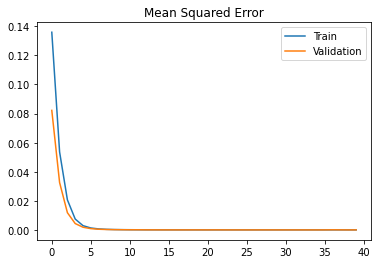

In [9]:
def visualising_data(hist):
    plt.title('Mean Squared Error')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.legend()
    plt.show()
visualising_data(history)

In [10]:
# shows weights of the ANN
# hypermodel.weights
hypermodel.summary()
# print(hypermodel.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 103)               4326      
_________________________________________________________________
dense_1 (Dense)              (None, 287)               29848     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                11520     
Total params: 45,694
Trainable params: 45,694
Non-trainable params: 0
_________________________________________________________________


In [11]:
# INSERT SOMETHING THAT CALCUALTES ALL MEAN SQUARED ERRORS AND PLOTS ON CDF GRAPH

In [12]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model_v2.h5')

# Transfer Learning

In [13]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
    hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [14]:
# hypermodel = keras.models.load_model('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

In [15]:
# hypermodel.summary()

In [16]:
# model = tf.keras.Sequential()
# for layer in hypermodel.layers[:-1]: # go through until last layer
#     layer.trainable=False
#     model.add(layer)
# model.add(keras.layers.Dense(40, activation='sigmoid'))
# model.summary()

# model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

In [17]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 207)               8694      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               62400     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                12040     
Total params: 83,134
Trainable params: 83,134
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 207)               8694      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               62400     
______________________________

In [18]:
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)

Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - ETA: 1:22 - loss: 0.2418 - mean_squared_error: 0.24 - ETA: 4s - loss: 0.1925 - mean_squared_error: 0.1925 - ETA: 2s - loss: 0.1606 - mean_squared_error: 0.16 - ETA: 1s - loss: 0.1343 - mean_squared_error: 0.13 - ETA: 0s - loss: 0.1150 - mean_squared_error: 0.11 - ETA: 0s - loss: 0.0994 - mean_squared_error: 0.09 - ETA: 0s - loss: 0.0875 - mean_squared_error: 0.08 - ETA: 0s - loss: 0.0780 - mean_squared_error: 0.07 - ETA: 0s - loss: 0.0701 - mean_squared_error: 0.07 - 1s 184us/sample - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2/40
7000/7000 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0

7000/7000 [==============================] - ETA: 0s - loss: 1.9940e-04 - mean_squared_error: 1.9940e- - ETA: 0s - loss: 2.4084e-04 - mean_squared_error: 2.4084e- - ETA: 0s - loss: 2.4058e-04 - mean_squared_error: 2.4058e- - ETA: 0s - loss: 2.3246e-04 - mean_squared_error: 2.3246e- - ETA: 0s - loss: 2.3328e-04 - mean_squared_error: 2.3328e- - ETA: 0s - loss: 2.2959e-04 - mean_squared_error: 2.2959e- - ETA: 0s - loss: 2.3147e-04 - mean_squared_error: 2.3147e- - ETA: 0s - loss: 2.3305e-04 - mean_squared_error: 2.3305e- - ETA: 0s - loss: 2.2860e-04 - mean_squared_error: 2.2860e- - ETA: 0s - loss: 2.2543e-04 - mean_squared_error: 2.2543e- - 1s 85us/sample - loss: 2.2454e-04 - mean_squared_error: 2.2454e-04 - val_loss: 2.1824e-04 - val_mean_squared_error: 2.1824e-04
Epoch 13/40
7000/7000 [==============================] - ETA: 0s - loss: 1.4635e-04 - mean_squared_error: 1.4635e- - ETA: 0s - loss: 1.9696e-04 - mean_squared_error: 1.9696e- - ETA: 0s - loss: 2.0559e-04 - mean_squared_error: 2.

Epoch 22/40
7000/7000 [==============================] - ETA: 0s - loss: 1.8604e-04 - mean_squared_error: 1.8604e- - ETA: 0s - loss: 1.4008e-04 - mean_squared_error: 1.4008e- - ETA: 0s - loss: 1.3610e-04 - mean_squared_error: 1.3610e- - ETA: 0s - loss: 1.3380e-04 - mean_squared_error: 1.3380e- - ETA: 0s - loss: 1.3197e-04 - mean_squared_error: 1.3197e- - ETA: 0s - loss: 1.2830e-04 - mean_squared_error: 1.2830e- - ETA: 0s - loss: 1.2596e-04 - mean_squared_error: 1.2596e- - ETA: 0s - loss: 1.2923e-04 - mean_squared_error: 1.2923e- - ETA: 0s - loss: 1.3029e-04 - mean_squared_error: 1.3029e- - ETA: 0s - loss: 1.2922e-04 - mean_squared_error: 1.2922e- - 1s 89us/sample - loss: 1.2859e-04 - mean_squared_error: 1.2859e-04 - val_loss: 1.3181e-04 - val_mean_squared_error: 1.3181e-04
Epoch 23/40
7000/7000 [==============================] - ETA: 0s - loss: 1.6115e-04 - mean_squared_error: 1.6115e- - ETA: 0s - loss: 1.3997e-04 - mean_squared_error: 1.3997e- - ETA: 0s - loss: 1.2901e-04 - mean_squar

7000/7000 [==============================] - ETA: 0s - loss: 9.8544e-05 - mean_squared_error: 9.8544e- - ETA: 0s - loss: 1.1817e-04 - mean_squared_error: 1.1817e- - ETA: 0s - loss: 1.1919e-04 - mean_squared_error: 1.1919e- - ETA: 0s - loss: 1.2147e-04 - mean_squared_error: 1.2147e- - ETA: 0s - loss: 1.2175e-04 - mean_squared_error: 1.2175e- - ETA: 0s - loss: 1.2000e-04 - mean_squared_error: 1.2000e- - ETA: 0s - loss: 1.2049e-04 - mean_squared_error: 1.2049e- - ETA: 0s - loss: 1.1975e-04 - mean_squared_error: 1.1975e- - ETA: 0s - loss: 1.1971e-04 - mean_squared_error: 1.1971e- - 1s 84us/sample - loss: 1.2079e-04 - mean_squared_error: 1.2079e-04 - val_loss: 1.2567e-04 - val_mean_squared_error: 1.2567e-04
Epoch 34/40
7000/7000 [==============================] - ETA: 0s - loss: 1.6395e-04 - mean_squared_error: 1.6395e- - ETA: 0s - loss: 1.2199e-04 - mean_squared_error: 1.2199e- - ETA: 0s - loss: 1.3091e-04 - mean_squared_error: 1.3091e- - ETA: 0s - loss: 1.2755e-04 - mean_squared_error: 1.

In [19]:
# evaluating transfer-learned model
eval_result = model.evaluate(X_test, Y_test, verbose=1)
# evaluating OLD model with new data
hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=1)
print(eval_result)
print(hypermodel_result)

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 60us/sample - loss: 1.2191e-04 - mean_squared_error: 1.2004e-04


1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.00012004390727573385, 0.000120043915]
[0.0007739679324440658, 0.000773968]


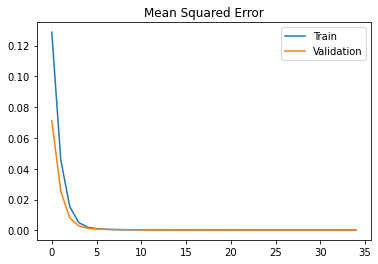

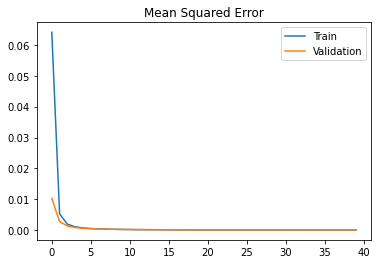

In [20]:
visualising_data(hypermodel_hist)
visualising_data(model.history)

In [21]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_EDFAs_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)
# evaluating transfer-learned model
eval_result = model.evaluate(X_test, Y_test)
# evaluating new model
hypermodel.evaluate(X_test, Y_test)

Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - ETA: 7s - loss: 1.0537e-04 - mean_squared_error: 1.0537e- - ETA: 0s - loss: 1.1384e-04 - mean_squared_error: 1.1384e- - ETA: 0s - loss: 1.1911e-04 - mean_squared_error: 1.1911e- - ETA: 0s - loss: 1.1891e-04 - mean_squared_error: 1.1891e- - ETA: 0s - loss: 1.1650e-04 - mean_squared_error: 1.1650e- - ETA: 0s - loss: 1.1571e-04 - mean_squared_error: 1.1571e- - ETA: 0s - loss: 1.1590e-04 - mean_squared_error: 1.1590e- - ETA: 0s - loss: 1.1657e-04 - mean_squared_error: 1.1657e- - ETA: 0s - loss: 1.1750e-04 - mean_squared_error: 1.1750e- - 1s 96us/sample - loss: 1.1818e-04 - mean_squared_error: 1.1818e-04 - val_loss: 1.1539e-04 - val_mean_squared_error: 1.1539e-04
Epoch 2/40
7000/7000 [==============================] - ETA: 1s - loss: 1.7742e-04 - mean_squared_error: 1.7742e- - ETA: 0s - loss: 1.1894e-04 - mean_squared_error: 1.1894e- - ETA: 0s - loss: 1.1644e-04 - mean_squared_error: 1.16

Epoch 12/40
7000/7000 [==============================] - ETA: 0s - loss: 8.6151e-05 - mean_squared_error: 8.6151e- - ETA: 0s - loss: 1.1793e-04 - mean_squared_error: 1.1793e- - ETA: 0s - loss: 1.1571e-04 - mean_squared_error: 1.1571e- - ETA: 0s - loss: 1.2201e-04 - mean_squared_error: 1.2201e- - ETA: 0s - loss: 1.2123e-04 - mean_squared_error: 1.2123e- - ETA: 0s - loss: 1.2033e-04 - mean_squared_error: 1.2033e- - ETA: 0s - loss: 1.2162e-04 - mean_squared_error: 1.2162e- - ETA: 0s - loss: 1.1975e-04 - mean_squared_error: 1.1975e- - ETA: 0s - loss: 1.1944e-04 - mean_squared_error: 1.1944e- - ETA: 0s - loss: 1.1980e-04 - mean_squared_error: 1.1980e- - 1s 93us/sample - loss: 1.1991e-04 - mean_squared_error: 1.1991e-04 - val_loss: 1.1841e-04 - val_mean_squared_error: 1.1841e-04
Epoch 13/40
7000/7000 [==============================] - ETA: 0s - loss: 6.6282e-05 - mean_squared_error: 6.6282e- - ETA: 0s - loss: 1.2764e-04 - mean_squared_error: 1.2764e- - ETA: 0s - loss: 1.2069e-04 - mean_squar

7000/7000 [==============================] - ETA: 0s - loss: 1.2700e-04 - mean_squared_error: 1.2700e- - ETA: 0s - loss: 1.2134e-04 - mean_squared_error: 1.2134e- - ETA: 0s - loss: 1.2680e-04 - mean_squared_error: 1.2680e- - ETA: 0s - loss: 1.2498e-04 - mean_squared_error: 1.2498e- - ETA: 0s - loss: 1.1891e-04 - mean_squared_error: 1.1891e- - ETA: 0s - loss: 1.2238e-04 - mean_squared_error: 1.2238e- - ETA: 0s - loss: 1.2261e-04 - mean_squared_error: 1.2261e- - ETA: 0s - loss: 1.2251e-04 - mean_squared_error: 1.2251e- - ETA: 0s - loss: 1.2202e-04 - mean_squared_error: 1.2202e- - 1s 83us/sample - loss: 1.2084e-04 - mean_squared_error: 1.2084e-04 - val_loss: 1.1610e-04 - val_mean_squared_error: 1.1610e-04
Epoch 23/40
7000/7000 [==============================] - ETA: 0s - loss: 7.8235e-05 - mean_squared_error: 7.8235e- - ETA: 0s - loss: 1.0851e-04 - mean_squared_error: 1.0851e- - ETA: 0s - loss: 1.1582e-04 - mean_squared_error: 1.1582e- - ETA: 0s - loss: 1.1771e-04 - mean_squared_error: 1.

7000/7000 [==============================] - ETA: 0s - loss: 6.4739e-05 - mean_squared_error: 6.4739e- - ETA: 0s - loss: 1.1198e-04 - mean_squared_error: 1.1198e- - ETA: 0s - loss: 1.1966e-04 - mean_squared_error: 1.1966e- - ETA: 0s - loss: 1.2069e-04 - mean_squared_error: 1.2069e- - ETA: 0s - loss: 1.2184e-04 - mean_squared_error: 1.2184e- - ETA: 0s - loss: 1.2293e-04 - mean_squared_error: 1.2293e- - ETA: 0s - loss: 1.2228e-04 - mean_squared_error: 1.2228e- - ETA: 0s - loss: 1.2150e-04 - mean_squared_error: 1.2150e- - ETA: 0s - loss: 1.2137e-04 - mean_squared_error: 1.2137e- - 1s 83us/sample - loss: 1.2177e-04 - mean_squared_error: 1.2177e-04 - val_loss: 1.1483e-04 - val_mean_squared_error: 1.1483e-04
Epoch 34/40
7000/7000 [==============================] - ETA: 0s - loss: 1.0573e-04 - mean_squared_error: 1.0573e- - ETA: 0s - loss: 1.1021e-04 - mean_squared_error: 1.1021e- - ETA: 0s - loss: 1.1476e-04 - mean_squared_error: 1.1476e- - ETA: 0s - loss: 1.1691e-04 - mean_squared_error: 1.

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 46us/sample - loss: 7.0589e-04 - mean_squared_error: 7.3480e-04


[0.0007347958077055713, 0.00073479576]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 207)               8694      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               62400     
_________________________________________________________________
dense_3 (Dense)              (None, 40)                12040     
Total params: 83,134
Trainable params: 12,040
Non-trainable params: 71,094
_________________________________________________________________
